In [3]:
from scipy.integrate import solve_ivp
from functools import partial
import numpy as np
import platform
import socket
from joblib import Parallel, delayed
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Label
from scipy.optimize import curve_fit
from scipy import odr
from scipy.integrate import solve_ivp
from functools import partial
from scipy.integrate import quad
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(10000)

In [4]:
Npoint = 1000
arr_mx = np.linspace(-1, 1, Npoint, endpoint=True)
arr_Ix = np.zeros(Npoint, dtype=np.float64)
arr_Iy = np.zeros(Npoint, dtype=np.float64)
arr_errx = np.zeros(Npoint, dtype=np.float64)
arr_erry = np.zeros(Npoint, dtype=np.float64)

G = 4.5 # отношение энергии Джозефсона к энергии магнитной анизотропии
r = 0.5 # параметр спин−орбитального взаимодействия
d = 0.3 # безразмерная длина джозефсоновского перехода
wF = 1  # собственная частота ферромагнитного резонанса
alpha = 0.01 # параметр гильбертовского затухания
V = 5  # напряжение в джозефсоновском переходе

t0 = 0
tf = 1500
nt = 15000

mx0 = -0.5
mz0 = 0
my0 = np.sqrt(1-mx0*mx0-mz0*mz0)

In [5]:
%%time
def jc0(d):
    '''Определяет функцию для критического тока при отсутствии F слоя'''
    result, error = quad(lambda phi: np.cos(phi) * np.exp(-d / np.cos(phi)),
                         -np.pi/2, np.pi/2)
    return result
Jc0 = jc0(d)
J0 = Jc0

def funct_Ix(phi, mx, r, d):
    return np.sin(phi) * np.exp(-d / np.cos(phi)) * np.sin(r * mx * np.tan(phi))

def funct_Iy(phi, mx, r, d):
    return np.cos(phi) * np.exp(-d / np.cos(phi)) * np.cos(r * mx * np.tan(phi))


CPU times: total: 0 ns
Wall time: 1 ms


In [6]:
%%time
def my_sfs(t, S, G, r, alpha, wF, d, V, J0, Ixfit, Iyfit):
    mx, my, mz = S

    # Вычисляем Jx и Jy только один раз
    Jx = Ixfit(mx)
    Jy = Iyfit(mx)

    # Предварительные вычисления для ускорения работы
    cos_Vt_rmy = np.cos(V*t - r*my)
    sin_Vt_rmy = np.sin(V*t - r*my)

    # Оптимизация Hx, Hy
    Hx = (G * r * Jx / J0) * (1 - cos_Vt_rmy)
    Hy = (G * r * Jy / J0) * sin_Vt_rmy + my
    Hz = 0  # Hz постоянен и равен 0

    # Используем numpy-векторизацию для более быстрых расчетов
    H = np.array([Hx, Hy, Hz])
    M = np.array([mx, my, mz])
    
    m2 = np.dot(M, M)
    HdM = np.dot(H, M)

    # Оптимизация с предвычислениями
    ksi = -wF / (1 + alpha**2 * m2)

    dmx = ksi * ((my*Hz - mz*Hy) + alpha * (mx * HdM - Hx * m2))
    dmy = ksi * ((mz*Hx - mx*Hz) + alpha * (my * HdM - Hy * m2))
    dmz = ksi * ((mx*Hy - my*Hx) + alpha * (mz * HdM - Hz * m2))

    return np.array([dmx, dmy, dmz])



CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
%%time
def compute_integrals(mx, r, d):
    Ix, errx = quad(funct_Ix, -np.pi/2, np.pi/2, args=(mx, r, d))
    Iy, erry = quad(funct_Iy, -np.pi/2, np.pi/2, args=(mx, r, d))
    return Ix, errx, Iy, erry

# параллельное выполнение
results = Parallel(n_jobs=-1)(delayed(compute_integrals)(mx, r, d) for mx in arr_mx)

# распаковка результатов
for ind, result in enumerate(results):
    arr_Ix[ind], arr_errx[ind], arr_Iy[ind], arr_erry[ind] = result
    

CPU times: total: 703 ms
Wall time: 2.72 s


In [8]:
%%time
def compute_odr_fit(data, degree):
    poly_model = odr.polynomial(degree)
    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()
    return np.poly1d(output.beta[::-1])

# создание данных для параллельного ODR
data_Ix = odr.Data(arr_mx, arr_Ix)
data_Iy = odr.Data(arr_mx, arr_Iy)
Ixfit = compute_odr_fit(data_Ix, 9)
Iyfit = compute_odr_fit(data_Iy, 8)

CPU times: total: 125 ms
Wall time: 122 ms


In [9]:
%%time
def integrate_interval(t_start, t_end):
    return solve_ivp(f, [t_start, t_end], s0, t_eval=np.linspace(t_start, t_end, nt//4), method='RK45', rtol=1e-8, atol=1e-8)

# Параллельная обработка
results = Parallel(n_jobs=40)(delayed(integrate_interval)(t_start, t_end) 
                              for t_start, t_end in [(0, 500), (500, 1000), (1000, 1500)])

# Объединяем результаты
sol_1 = np.concatenate([res.y for res in results], axis=1)

NameError: name 'f' is not defined

In [10]:
sol_1

NameError: name 'sol_1' is not defined

AttributeError: 'numpy.ndarray' object has no attribute 't'

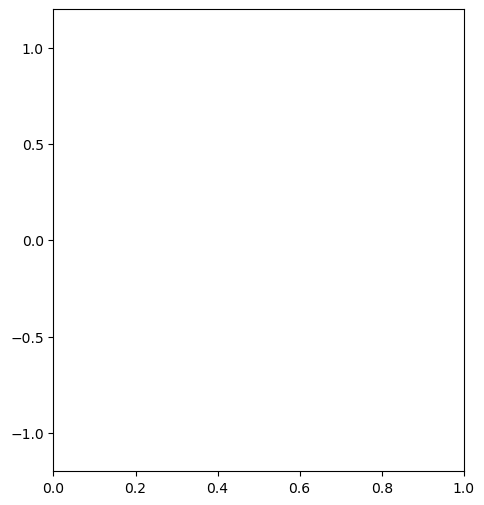

In [17]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.ylim(-1.2, 1.2)
plt.plot(sol_1.t, sol_1.y[0], label='Компонента $m_x $', color='b')
plt.xlabel('t', size=16)
plt.ylabel('$m_{x}$', size=16)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.ylim(-1.2, 1.2)
plt.plot(sol_1.t, sol_1.y[1], label='Компонента $m_y $', color='g')
plt.xlabel('t', size=16)
plt.ylabel('$m_{y}$', size=16)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.ylim(-1.2, 1.2)
plt.plot(sol_1.t, sol_1.y[2], label='Компонента $m_z $', color='r')
plt.xlabel('t', size=16)
plt.ylabel('$m_{z}$', size=16)
plt.legend(fontsize=12)
plt.show()
